## **Лабораторная работа 4 (Diamonds Prices)**

In [1]:
import pandas as pd
df = pd.read_csv(".//static//csv//Diamonds Prices2022.csv")
print(df.info)

<bound method DataFrame.info of        Unnamed: 0  carat        cut color clarity  depth  table  price     x  \
0               1   0.23      Ideal     E     SI2   61.5   55.0    326  3.95   
1               2   0.21    Premium     E     SI1   59.8   61.0    326  3.89   
2               3   0.23       Good     E     VS1   56.9   65.0    327  4.05   
3               4   0.29    Premium     I     VS2   62.4   58.0    334  4.20   
4               5   0.31       Good     J     SI2   63.3   58.0    335  4.34   
...           ...    ...        ...   ...     ...    ...    ...    ...   ...   
53938       53939   0.86    Premium     H     SI2   61.0   58.0   2757  6.15   
53939       53940   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83   
53940       53941   0.71    Premium     E     SI1   60.5   55.0   2756  5.79   
53941       53942   0.71    Premium     F     SI1   59.8   62.0   2756  5.74   
53942       53943   0.70  Very Good     E     VS2   60.5   59.0   2757  5.71   

       

### **Задача регрессии**

#### **Бизнес-цель для задачи регрессии**

Предсказать цену бриллианта на основе его характеристик

Зачем это нужно?

Для покупателей: Упрощение выбора бриллианта, основываясь на соотношении цена-качество.

Для продавцов: Оптимизация ценовой политики и привлечение клиентов за счет точного ценообразования.

Для оценщиков: Ускорение процесса оценки бриллиантов и снижение субъективности

#### **Достижимый уровень качества модели для задачи регрессии:**

**Целевой уровень:** MAE < 300, R² > 0.97. 

**Основание:** это позволяет достичь приемлемой точности для предсказания цен бриллиантов с учетом их характеристик.



### **Линейная регрессия**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import sklearn.preprocessing as preproc
import numpy as np

df = pd.read_csv(".//static//csv//Diamonds Prices2022.csv")
data = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price']]

# Преобразуем категориальные признаки в числовые через one-hot encoding
data = pd.get_dummies(data, columns=['cut', 'color', 'clarity'], drop_first=True)

# Определение входных и целевых переменных
X = data.drop('price', axis=1)  # признаки
y = data['price']  # целевая переменная (цена)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Подготовка пайплайна для линейной регрессии
pipeline_lin_reg = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), X.columns)  
    ])),
    ('model', LinearRegression()) 
])

# Определение сетки гиперпараметров для поиска лучших значений
param_grid = {
    'preprocessing': [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), None]  # разные методы масштабирования
}

# Создание объекта GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(pipeline_lin_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель линейной регрессии
best_model = grid_search.best_estimator_

# Прогнозирование на тестовых данных
y_pred = best_model.predict(X_test)

# Оценка модели: Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Cредняя абсолютная ошибка (MAE) = {mae}')

# Оценка качества модели: R^2
r2 = r2_score(y_test, y_pred)
print(f'R^2 = {r2}')

# Оценка дисперсии и смещения
cv_results = grid_search.cv_results_
mean_test_score = np.mean(cv_results['mean_test_score'])
std_test_score = np.std(cv_results['mean_test_score'])

print(f"Смещение: {mean_test_score}")
print(f"Дисперсия: {std_test_score}")

Лучшие гиперпараметры:  {'preprocessing': MaxAbsScaler()}
Cредняя абсолютная ошибка (MAE) = 731.547938145698
R^2 = 0.9221982562588074
Смещение: -1138.4103165293116
Дисперсия: 4.4030722917880405e-13


### **Градиентный бустинг**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict

# Преобразование числовых данных (заполнение пустых значений медианой)
num_imputer = SimpleImputer(strategy="median")
preprocessing_num = Pipeline([("imputer", num_imputer)])

# Общая предобработка (только числовые данные)
preprocessing = ColumnTransformer(
    [("nums", preprocessing_num, X_train.columns)]
)

# Конвейер
pipeline_grad = Pipeline([
    ('preprocessing', preprocessing),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Определение сетки гиперпараметров
param_grid = {
    'preprocessing': [StandardScaler(), preproc.MinMaxScaler(), preproc.MaxAbsScaler(), None],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(pipeline_grad, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель градиентного бустинга
best_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# Оценка качества
print(f'Cредняя абсолютная ошибка (MAE) = {mean_absolute_error(y_test, y_pred)}')

# Предсказания на кросс-валидации
y_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=3)

# Оценка смещения и дисперсии
cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

# Коэффициент детерминации R^2
print(f'R^2 = {r2_score(y_test, y_pred)}')



Лучшие гиперпараметры:  {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300, 'preprocessing': StandardScaler()}
Cредняя абсолютная ошибка (MAE) = 282.34135362359893
Смещение: -696.9996831010233
Дисперсия: 4.393470605801296
R^2 = 0.9790739156988512


### **Случаные леса**

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Конвейер
pipeline_forest = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor(random_state=42))
])

# Определение сетки гиперпараметров
param_grid = {
    'preprocessing': [StandardScaler(), preproc.MinMaxScaler(), preproc.MaxAbsScaler(), None],
    'model__n_estimators': [100, 200, 300],  # Количество деревьев
    'model__max_depth': [None, 5, 10],       # Максимальная глубина деревьев
    'model__min_samples_split': [2, 5],      # Минимальное число образцов для разделения
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(pipeline_forest, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель случайного леса
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print(f'Средняя абсолютная ошибка (MAE) = {mean_absolute_error(y_test, y_pred)}')

# Получение предсказаний на кросс-валидации
y_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=3)

cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

print(f'R^2 = {r2_score(y_test, y_pred)}')

Лучшие гиперпараметры:  {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 300, 'preprocessing': None}
Средняя абсолютная ошибка (MAE) = 292.2620729910037
Смещение: -882.5346885343729
Дисперсия: 11.135626719319792
R^2 = 0.9743449800931261


### **Вывод:**

**Линейная регрессия:**

MAE: 731.55 — наибольшая ошибка среди моделей.

R²: 0.9222 — показывает, что модель объясняет 92.2% дисперсии, но хуже справляется с нелинейными зависимостями.

Смещение: -1138.41 — модель недооценивает значения (высокое смещение).

Дисперсия: 4.40e-13 — практически нулевая, модель стабильна.

Вывод: Линейная регрессия не справляется с учетом сложных взаимосвязей между признаками.

**Градиентный бустинг:**

MAE: 282.34 — самая низкая ошибка, лучшая модель.

R²: 0.9791 — объясняет 97.9% дисперсии, хорошо справляется с нелинейными зависимостями.

Смещение: -696.99 — приемлемое смещение, модель лучше оценивает данные.

Дисперсия: 4.39 — модель стабильна.

Вывод: Градиентный бустинг — наиболее точная и сбалансированная модель.

**Случайные леса:**

MAE: 292.26 — немного хуже, чем у градиентного бустинга.

R²: 0.9743 — объясняет 97.4% дисперсии.

Смещение: -882.53 — модель недооценивает значения сильнее, чем градиентный бустинг.

Дисперсия: 11.13 — несколько выше, чем у других моделей.

Вывод: Случайные леса также подходят для задачи, но уступают градиентному бустингу.

**Градиентный бустинг выбран как лучшая модель из-за низкого MAE и сбалансированных смещения и дисперсии. Случайные леса также могут быть использованы, но с дополнительной настройкой гиперпараметров.**

### **Задача классификация**

#### **Бизнес-цель для задачи регрессии** 

Спрогнозировать категорию огранки бриллианта.

Это поможет:

1. Улучшить процессы оценки качества бриллиантов.
2. Упростить классификацию для ювелирных компаний.
3. Повысить точность ценообразования и автоматизировать принятие решений.


Спрогнозировать категорию категория огранки на основе его характеристик

### **Метрики в задаче классификации**
ROC AUC: Измеряет способность модели разделять классы. Чем ближе к 1, тем лучше.

Точность (Accuracy): Доля правильно классифицированных объектов.

Смещение: Показывает, насколько среднее значение предсказаний отличается от истинного класса.

Дисперсия: Описывает изменчивость предсказаний модели при разных обучающих наборах.


### **Достижимый уровень качества модели для задачи классификации**

Целевой уровень: ROC AUC > 0.99, Точность > 0.95.

Основание: Эти значения обеспечивают высокую точность и надежность при прогнозировании категории огранки бриллианта, минимизируя количество ошибок и повышая доверие к автоматизированной системе оценки качества.

### **Логистическая регрессия**

c:\D\semester5\mii\aimenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Лучшие гиперпараметры:  {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
ROC AUC у логистической регрессии = 0.9869744388185762
Точность = 0.9338214848456762


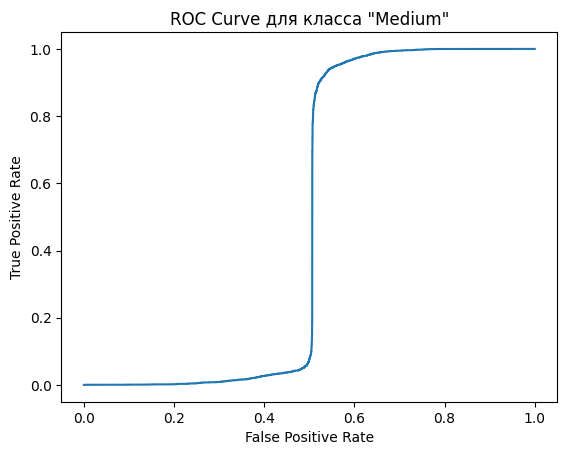

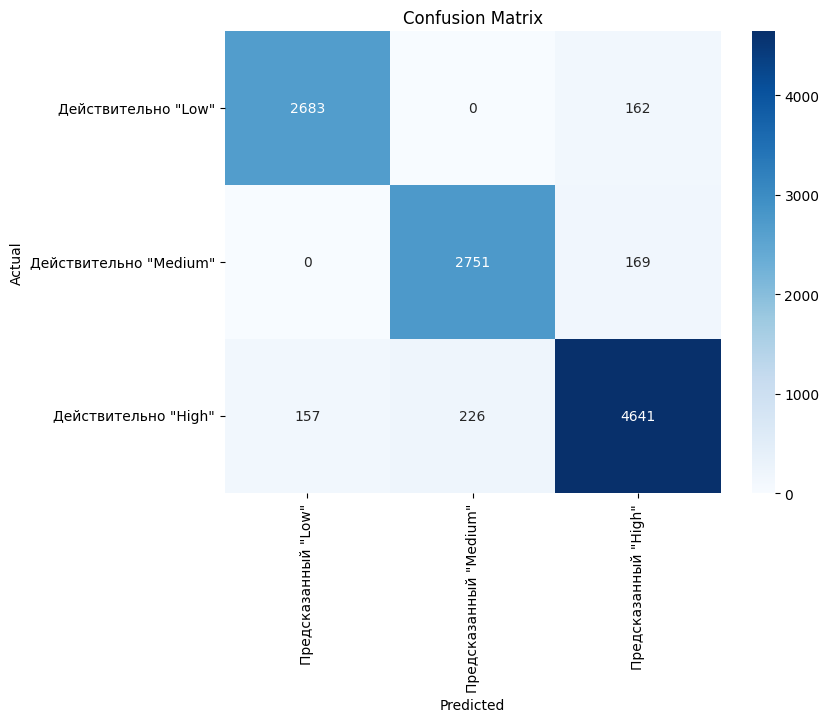

Смещение: 0.9311110918680002
Дисперсия: 0.00184041613203153


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

df = pd.read_csv(".//static//csv//Diamonds Prices2022.csv")

df.columns = df.columns.str.strip()

# Создание целевой переменной на основе столбца 'price'
bins = [0, 1000, 5000, float('inf')]
labels = ['Low', 'Medium', 'High']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)

# Преобразуем целевую переменную в категориальный тип
y = pd.Categorical(df['price_category'])

# Подготовка данных
data = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price_category']]  # Целевая переменная - 'price_category'
X = data.drop('price_category', axis=1)  # Признаки
y = data['price_category']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование числовых данных
num_imputer = SimpleImputer(strategy="median")  # Замена пропусков медианой
num_scaler = StandardScaler()  # Стандартизация
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Преобразование категориальных данных
cat_imputer = SimpleImputer(strategy="most_frequent")  # Заполнение пропусков наиболее частым значением
cat_encoder = OneHotEncoder(handle_unknown='ignore')  # Преобразование категориальных признаков в OneHot
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Общая предобработка
preprocessing = ColumnTransformer(
    [
        ("nums", preprocessing_num, X.select_dtypes(include=['float64', 'int64']).columns),  # Числовые признаки
        ("cats", preprocessing_cat, X.select_dtypes(include=['object']).columns),  # Категориальные признаки
    ]
)

# Конвейер для логистической регрессии
pipeline_logreg = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear'))  # Указание решателя и метода многоклассовой классификации
])

# Определение сетки гиперпараметров
param_grid = {
    'classifier__C': [0.1, 0.5, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Создание объекта GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(pipeline_logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель логистической регрессии
best_model = grid_search.best_estimator_

# Использование и оценка лучшей логистической модели
y_pred_proba = best_model.predict_proba(X_test)  # Получаем вероятности для всех классов

# Для многоклассовой классификации AUC считается для каждого класса
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC у логистической регрессии = {roc_auc}')

y_pred = best_model.predict(X_test)
print(f'Точность = {accuracy_score(y_test, y_pred)}')

# Построение ROC кривой для каждого класса
# Пример для класса "Medium"
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:, 1], pos_label='Medium')
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve для класса "Medium"')
plt.show()

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказанный "Low"', 'Предсказанный "Medium"', 'Предсказанный "High"'], 
            yticklabels=['Действительно "Low"', 'Действительно "Medium"', 'Действительно "High"'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Оценка смещения и дисперсии
cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

### **Градиентный букинг**

Лучшие гиперпараметры:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
ROC AUC у градиентного бустинга = 0.99543134281693
Точность = 0.9507832051163222


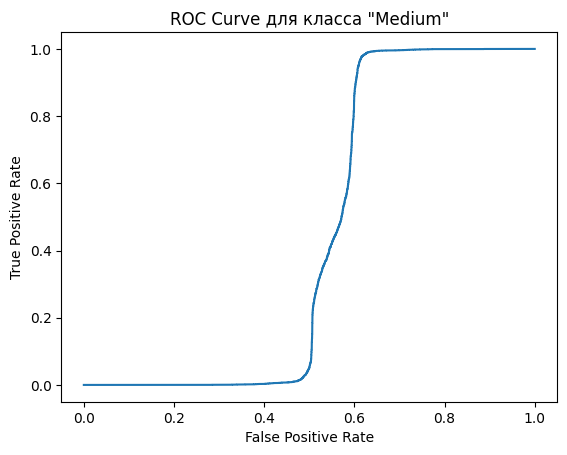

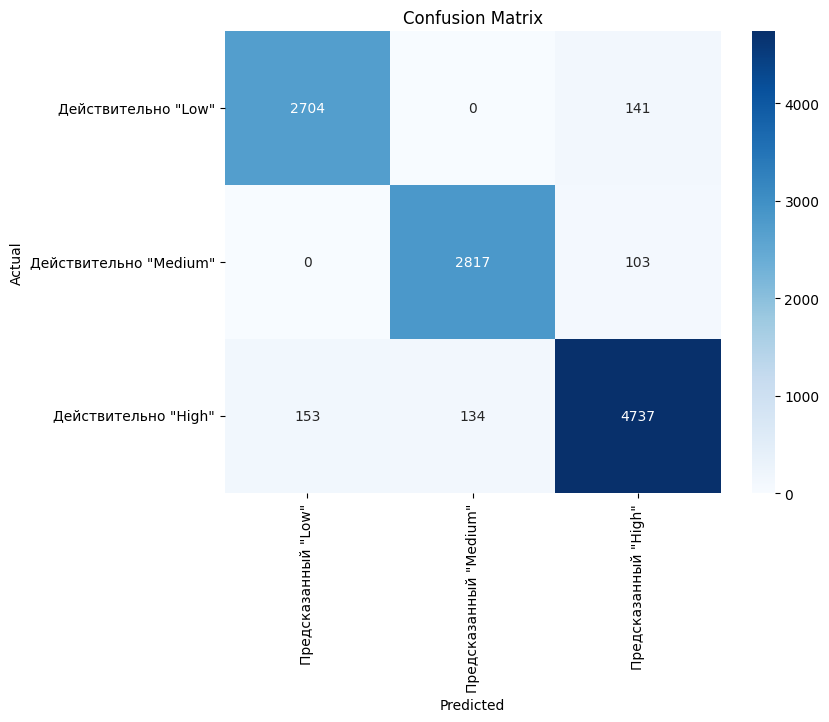

Смещение: 0.9380732054788211
Дисперсия: 0.003201824240012704


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

df = pd.read_csv(".//static//csv//Diamonds Prices2022.csv")

df.columns = df.columns.str.strip()

# Создание целевой переменной на основе столбца 'price'
bins = [0, 1000, 5000, float('inf')]
labels = ['Low', 'Medium', 'High']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)

# Преобразуем целевую переменную в категориальный тип
y = pd.Categorical(df['price_category']) 

# Подготовка данных
data = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price_category']]  # Целевая переменная - 'price_category'
X = data.drop('price_category', axis=1)  # Признаки
y = data['price_category']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование числовых данных
num_imputer = SimpleImputer(strategy="median")  # Замена пропусков медианой
num_scaler = StandardScaler()  # Стандартизация
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Преобразование категориальных данных
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_encoder = OneHotEncoder(handle_unknown='ignore')  
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Общая предобработка
preprocessing = ColumnTransformer(
    [
        ("nums", preprocessing_num, X.select_dtypes(include=['float64', 'int64']).columns),
        ("cats", preprocessing_cat, X.select_dtypes(include=['object']).columns),
    ]
)

# Конвейер для градиентного бустинга
pipeline_gbc = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', GradientBoostingClassifier(random_state=42))  # Градиентный бустинг
])

# Определение сетки гиперпараметров для градиентного бустинга
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0]
}

# Создание объекта GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(pipeline_gbc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель градиентного бустинга
best_model = grid_search.best_estimator_

# Использование и оценка лучшей модели
y_pred_proba = best_model.predict_proba(X_test)  # Получаем вероятности для всех классов

# Для многоклассовой классификации AUC считается для каждого класса
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC у градиентного бустинга = {roc_auc}')

y_pred = best_model.predict(X_test)
print(f'Точность = {accuracy_score(y_test, y_pred)}')

# Построение ROC кривой для каждого класса
# Пример для класса "Medium"
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:, 1], pos_label='Medium')
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve для класса "Medium"')
plt.show()

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказанный "Low"', 'Предсказанный "Medium"', 'Предсказанный "High"'], 
            yticklabels=['Действительно "Low"', 'Действительно "Medium"', 'Действительно "High"'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Оценка смещения и дисперсии
cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

### **Случайный лес**

Лучшие гиперпараметры:  {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20}
ROC AUC для случайного леса = 0.9946705103108209
Точность = 0.9466122902956715


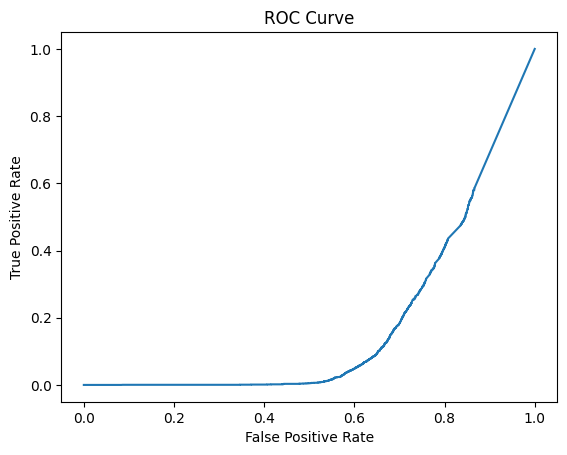

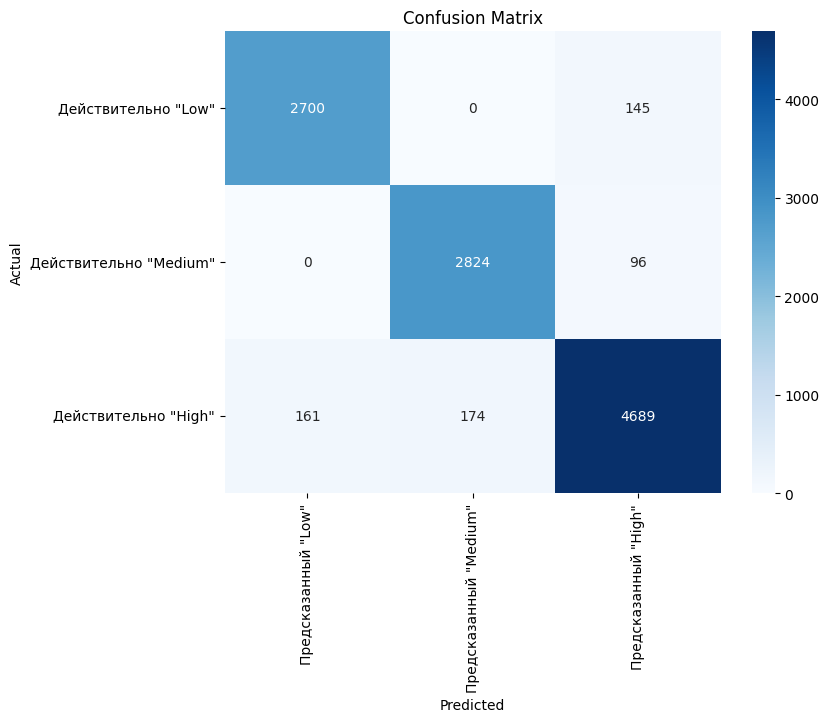

Смещение: 0.942448004061997
Дисперсия: 0.003142805279982323


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

df = pd.read_csv(".//static//csv//Diamonds Prices2022.csv")

# Убираем пробелы в именах столбцов, если есть
df.columns = df.columns.str.strip()

# Создание целевой переменной на основе столбца 'price'
bins = [0, 1000, 5000, float('inf')]
labels = ['Low', 'Medium', 'High']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)

# Преобразуем целевую переменную в категориальный тип
y = pd.Categorical(df['price_category'])

# Подготовка данных
data = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price_category']]  # Целевая переменная - 'price_category'
X = data.drop('price_category', axis=1)  # Признаки
y = data['price_category']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование числовых данных
num_imputer = SimpleImputer(strategy="median")  # Замена пропусков медианой
num_scaler = StandardScaler()  # Стандартизация
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Преобразование категориальных данных
cat_imputer = SimpleImputer(strategy="most_frequent")  # Заполнение пропусков наиболее частым значением
cat_encoder = OneHotEncoder(handle_unknown='ignore')  # Преобразование категориальных признаков в OneHot
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Общая предобработка
preprocessing = ColumnTransformer(
    [
        ("nums", preprocessing_num, X.select_dtypes(include=['float64', 'int64']).columns),  # Числовые признаки
        ("cats", preprocessing_cat, X.select_dtypes(include=['object']).columns),  # Категориальные признаки
    ]
)

# Конвейер для случайного леса
pipeline_rf = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))  # Модель случайного леса
])

# Определение сетки гиперпараметров
param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # Количество деревьев
    'classifier__max_depth': [10, 20, None],  # Глубина деревьев
    'classifier__min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения
    'classifier__min_samples_leaf': [1, 2, 4],  # Минимальное количество образцов в листьях
    'classifier__max_features': ['sqrt', 'log2']  # Количество признаков для каждого дерева
}

# Создание объекта RandomizedSearchCV для поиска лучших гиперпараметров
random_search = RandomizedSearchCV(pipeline_rf, param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Обучение модели с перебором гиперпараметров
random_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", random_search.best_params_)

# Лучшая модель случайного леса
best_model = random_search.best_estimator_

# Использование и оценка лучшей модели случайного леса
y_pred_proba = best_model.predict_proba(X_test)  # Получаем вероятности для всех классов

# Для многоклассовой классификации используем roc_auc_score с multi_class='ovr'
print(f'ROC AUC для случайного леса = {roc_auc_score(y_test, y_pred_proba, multi_class="ovr")}')

y_pred = best_model.predict(X_test)
print(f'Точность = {accuracy_score(y_test, y_pred)}')

# Построение ROC кривой для многоклассовой задачи
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:, 2], pos_label='High')  # Указываем класс для которого строим ROC
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказанный "Low"', 'Предсказанный "Medium"', 'Предсказанный "High"'], 
            yticklabels=['Действительно "Low"', 'Действительно "Medium"', 'Действительно "High"'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Оценка смещения и дисперсии
cv_results = random_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

### **Вывод:**

Градиентный бустинг показал наивысший ROC AUC (0.995) и точность (0.951), но имеет высокую дисперсию (0.0032). Это указывает на более сложные зависимости, которые модель способна уловить.

Случайный лес близок по качеству к градиентному бустингу (ROC AUC = 0.995, точность = 0.947), при этом демонстрирует меньшую дисперсию. Это делает его более стабильным при изменении данных.

Логистическая регрессия уступает обоим ансамблевым методам, но имеет минимальную дисперсию (0.0018), что делает её менее подверженной переобучению.